In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from scipy.optimize import minimize_scalar, minimize

def helstrom_operator(q0, rho0, rho1):
    return q0*rho0 - (1-q0)*rho1

In [94]:
def pauli_matrices(string):
    if string == 'x':
        return np.array([[0, 1], [1, 0]])
    elif string == 'y':
        return np.array([[0, -1j], [1j,0]])
    elif string == 'z':
        return np.array([[1, 0], [0, -1]])

def identity_matrix(n):
    return np.identity(n)

In [104]:
def simple_qubit_example(nu, pauli_matrix):
    i2 = identity_matrix(2)
    rho0 = (i2 + (1-nu)*pauli_matrix)/2
    rho1 = (i2 - (1-nu)*pauli_matrix)/2
    return rho0, rho1

def more_complex_qubit_example(nu):
    i2 = np.eye(2)
    rho0 = (i2 + (1 - nu)*(pauli_matrices('y')*np.sin(np.pi/4) + pauli_matrices('z')*np.cos(np.pi/4)))/2
    rho1 = (i2 + (1 - nu)*(pauli_matrices('y')*np.sin(np.pi/4) - pauli_matrices('z')*np.cos(np.pi/4)))/2
    return rho0, rho1

def nontrivial_mixed_qubit_states(nu):
    """
    Return a nontrivial pair of mixed qubit states with non-parallel Bloch vectors.

    Parameters:
        nu (float): controls the degree of mixedness, 0 <= nu <= 1

    Returns:
        rho0, rho1 (2x2 np.array): two valid qubit density matrices
    """
    # Ensure nu ∈ [0, 1]
    assert 0 <= nu <= 1

    # Use normalized but distinct Bloch directions
    r0 = (1 - nu) * np.array([0.6, 0.6, 0.3])  # not aligned with axes
    r1 = (1 - nu) * np.array([-0.2, 0.7, -0.6])  # tilted differently

    # Build rho = 1/2 * (I + r · σ)
    I = np.eye(2)

    def bloch_to_rho(r):
        return 0.5 * (I + r[0]*pauli_matrices('x') + r[1]*pauli_matrices('y') + r[2]*pauli_matrices('z'))

    rho0 = bloch_to_rho(r0)
    rho1 = bloch_to_rho(r1)

    return rho0, rho1


In [118]:
def random_qubit_pure_state():
    """
    Generate a random qubit pure state |ψ⟩ = cos(θ/2)|0⟩ + e^{iφ}sin(θ/2)|1⟩
    """
    theta = 2 * np.arccos(np.sqrt(np.random.rand()))
    phi = 2 * np.pi * np.random.rand()
    return np.array([
        np.cos(theta / 2),
        np.exp(1j * phi) * np.sin(theta / 2)
    ])

def mixture_of_pure_states(num_pure_states=3):
    """
    Generate a random mixed qubit state as a convex combination of random pure states.
    """
    probs = np.random.rand(num_pure_states)
    probs /= np.sum(probs)

    rho = np.zeros((2, 2), dtype=np.complex128)
    for p in probs:
        psi = random_qubit_pure_state()
        rho += p * np.outer(psi, psi.conj())
    return rho

def generate_mixed_state_pair(n=200, m=200):
    """
    Generate a pair of mixed qubit states from classical mixtures over pure states.

    Parameters:
        n, m: number of pure states to mix for rho0 and rho1 respectively.

    Returns:
        rho0, rho1: two 2x2 density matrices
    """
    rho0 = mixture_of_pure_states(n)
    rho1 = mixture_of_pure_states(m)
    return rho0, rho1


In [47]:
def func_for_POVM(gamma, mu, nu, xi, eps, theta, phi):
    U = np.exp(1j * gamma) * np.array([
        [np.exp(1j * mu) * np.cos(xi),     np.exp(1j * nu) * np.sin(xi)],
        [-np.exp(-1j * nu) * np.sin(xi),   np.exp(-1j * mu) * np.cos(xi)]
    ], dtype=np.complex128)
    D = np.array([
        [np.exp(1j * eps) * np.cos(theta), 0],
        [0, np.cos(phi)]
    ], dtype=np.complex128)
    F0 = U.conj().T @ D @ D @ U
    F0 = (F0 + F0.conj().T) / 2
    F1 = identity_matrix(2) - F0
    return F0, F1

In [71]:

def minimum_error_probability(rho0, rho1, q, num_restarts=50):
    def objective(x):
        gamma, mu, nu, xi, eps, theta, phi = x

        # Construct U
        U = np.exp(1j * gamma) * np.array([
            [np.exp(1j * mu) * np.cos(xi),     np.exp(1j * nu) * np.sin(xi)],
            [-np.exp(-1j * nu) * np.sin(xi),   np.exp(-1j * mu) * np.cos(xi)]
        ], dtype=np.complex128)

        # Construct D
        D = np.array([
            [np.exp(1j * eps) * np.cos(theta), 0],
            [0, np.cos(phi)]
        ], dtype=np.complex128)

        # Construct F0
        F0 = U.conj().T @ D @ D @ U
        F0 = (F0 + F0.conj().T) / 2  # enforce Hermiticity

        # Penalize if F0 has negative eigenvalues
        eigvals = np.linalg.eigvalsh(F0)
        if np.any(eigvals < -1e-10):  # allow tiny negative values due to rounding
            return 1e6  # Penalize hard

        # Compute cost
        delta = q * rho0 - (1 - q) * rho1
        val = np.trace(delta @ F0).real

        if not np.isfinite(val):
            return 1e6  # Penalize invalid result

        return q - val

    bounds = [
        (0, 2*np.pi),   # gamma
        (0, 2*np.pi),   # mu
        (0, 2*np.pi),   # nu
        (0, 0.5*np.pi), # xi
        (0, 2*np.pi),   # eps
        (0, 0.5*np.pi), # theta
        (0, 0.5*np.pi)  # phi
    ]

    best_fun = float('inf')
    best_x = None
    best_res = None

    for _ in range(num_restarts):
        x0 = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
        res = minimize(objective, x0=x0, bounds=bounds, method='L-BFGS-B')

        if res.success and res.fun < best_fun:
            best_fun = res.fun
            best_x = res.x
            best_res = res

    if best_res is None:
        raise RuntimeError("All optimization attempts failed.")

    return best_fun, best_x


In [72]:
rho0, rho1 = simple_qubit_example(0.8, pauli_matrices('z'))

In [73]:
cost, angles = minimum_error_probability(rho0, rho1, 1/2)

In [74]:
angles

array([3.33690077, 3.23489355, 2.49027311, 0.        , 0.        ,
       0.        , 1.57079633])

In [75]:
cost

np.float64(0.4)

In [76]:
E0, E1 = func_for_POVM(*angles)
E0 + E1

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [77]:
E0

array([[1.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 3.74939946e-33+0.j]])

In [78]:
E1

array([[-2.22044605e-16+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  1.00000000e+00+0.j]])

In [69]:
def is_valid_povm(povm_set, tol=1e-10):
    """
    Check if a list of matrices forms a valid POVM.
    
    Parameters:
        povm_set: list of numpy arrays (POVM elements)
        tol: numerical tolerance for equality checks
        
    Returns:
        True if the set is a valid POVM, False otherwise
    """
    d = povm_set[0].shape[0]
    
    # 1. Check Hermiticity and Positive Semidefiniteness
    for i, E in enumerate(povm_set):
        if not np.allclose(E, E.conj().T, atol=tol):
            print(f"Operator E[{i}] is not Hermitian.")
            return False

        # Check all eigenvalues are >= 0
        eigvals = np.linalg.eigvalsh(E)
        if np.any(eigvals < -tol):
            print(f"Operator E[{i}] has negative eigenvalues: {eigvals}")
            return False

    # 2. Check completeness: sum_i E_i = I
    total = sum(povm_set)
    if not np.allclose(total, np.eye(d), atol=tol):
        print("Sum of POVM elements is not the identity.")
        return False

    return True

In [70]:
is_valid_povm([E0, E1])

True

In [83]:
def state_copies(rho, M):
    result = rho
    for _ in range(M-1):
        result = np.kron(result, rho)
    return result

In [111]:
def helstrom_bound(q, rho0, rho1):
    delta = q * rho0 - (1 - q) * rho1
    eigvals = np.linalg.eigvalsh(delta)  # Hermitian, so use eigvalsh
    trace_norm = np.sum(np.abs(eigvals))  # trace norm = sum of abs eigenvalues
    return 0.5 * (1 - trace_norm)


In [54]:
helstrom_bound(1/2, rho0, rho1)

np.float64(0.4292893218813453)

In [79]:
def chernoff_error_exponent(rho0, rho1):
    def chernoff_coefficient(s):
        product = np.dot(fractional_matrix_power(rho0, s), fractional_matrix_power(rho1, 1-s))
        return np.real(np.trace(product))

    res = minimize_scalar(chernoff_coefficient, bounds=(0,1), method='bounded')

    if not res.success:
        raise RuntimeError("Minimization Failed")

    c_opt = res.fun
    return -np.log(c_opt)

In [8]:
def get_helstrom_povm_multicopy(rho_plus: np.ndarray, rho_minus: np.ndarray, M: int = 1):
    """
    Returns the Helstrom POVM (Pi_plus, Pi_minus) for M-copy discrimination between
    rho_plus and rho_minus (equal priors assumed).

    Requires: state_copies(rho, M)
    """
    # Use user-defined Kronecker power function
    rho_plus_M = state_copies(rho_plus, M)
    rho_minus_M = state_copies(rho_minus, M)

    # Helstrom operator: delta = q * rho_plus_M - (1 - q) * rho_minus_M with q = 1/2
    delta = 0.5 * (rho_plus_M - rho_minus_M)

    eigvals, eigvecs = np.linalg.eigh(delta)

    # Construct POVM elements from eigenvectors
    Pi_plus = np.zeros_like(delta)
    Pi_minus = np.zeros_like(delta)

    for i in range(len(eigvals)):
        projector = np.outer(eigvecs[:, i], eigvecs[:, i])
        if eigvals[i] > 0:
            Pi_plus += projector
        else:
            Pi_minus += projector

    return Pi_plus, Pi_minus

In [9]:
#def simulate_one_measurement(rho_plus, rho_minus, Pi_plus, Pi_minus, M=1):
#    """
#    Simulates a single measurement trial.
#    Randomly selects one of the true states (equal priors), applies the M-copy Helstrom POVM,
#    and returns the guessed label and true label.
#    """
    # Choose true state randomly (equal priors)
#    true_label = np.random.choice([+1, -1])

    # Get the true state
#    rho_true = rho_plus if true_label == +1 else rho_minus
#    rho_true_M = state_copies(rho_true, M)

    # Compute probabilities of each POVM outcome
#    p_plus = np.real(np.trace(Pi_plus @ rho_true_M))
#    p_minus = np.real(np.trace(Pi_minus @ rho_true_M))

    # Sample outcome from probabilities
#    outcome = np.random.choice([+1, -1], p=[p_plus, p_minus])

#    return outcome, true_label


In [84]:
def simulate_majority_vote(rho_plus, rho_minus, Pi_plus, Pi_minus, N, M=1):
    """
    Simulates N independent single-copy measurements and returns whether
    the majority vote is correct.
    """
    # Choose one true label for all copies in this trial
    true_label = np.random.choice([+1, -1])
    rho_true = rho_plus if true_label == +1 else rho_minus

    votes = []

    for _ in range(N):
        rho_true_M = state_copies(rho_true, M)
        p_plus = np.real(np.trace(Pi_plus @ rho_true_M))
        p_minus = np.real(np.trace(Pi_minus @ rho_true_M))
        vote = np.random.choice([+1, -1], p=[p_plus, p_minus])
        votes.append(vote)

    vote_total = np.sum(votes)
    guess = +1 if vote_total > 0 else -1  # Tie breaks to -1
    is_correct = (guess == true_label)

    return is_correct


In [85]:
def estimate_error_exponent(rho_plus, rho_minus, Pi_plus, Pi_minus, N, num_trials=10000, M=1):
    """
    Runs num_trials majority-vote simulations for N single-copy measurements.
    Returns estimated error probability and error exponent ε_N = -log(Pe)/N
    """
    num_errors = 0

    for _ in range(num_trials):
        correct = simulate_majority_vote(rho_plus, rho_minus, Pi_plus, Pi_minus, N, M)
        if not correct:
            num_errors += 1

    P_err = num_errors / num_trials
    if P_err == 0:
        epsilon_N = np.inf  # perfect classification
    else:
        epsilon_N = -np.log(P_err) / N

    return P_err, epsilon_N


In [90]:
v = 0.8
rho_plus, rho_minus = simple_qubit_example(0.8, pauli_matrices('z'))
#Pi_plus, Pi_minus = get_helstrom_povm_multicopy(rho_plus, rho_minus, M=1)
set_of_P_err = []
set_of_eps_N = []

for N in range(1, 150):
    P_err, epsilon_N = estimate_error_exponent(rho_plus, rho_minus, E0, E1, N, num_trials=10000)
    print(f"N = {N} → P_err = {P_err:.5f}, ε_N = {epsilon_N:.5f}")
    set_of_eps_N.append(epsilon_N)
    set_of_P_err.append(P_err)


N = 1 → P_err = 0.40130, ε_N = 0.91305
N = 2 → P_err = 0.39870, ε_N = 0.45977
N = 3 → P_err = 0.34940, ε_N = 0.35051
N = 4 → P_err = 0.35170, ε_N = 0.26124
N = 5 → P_err = 0.31880, ε_N = 0.22864
N = 6 → P_err = 0.32600, ε_N = 0.18681
N = 7 → P_err = 0.28860, ε_N = 0.17753
N = 8 → P_err = 0.29290, ε_N = 0.15349
N = 9 → P_err = 0.26490, ε_N = 0.14760
N = 10 → P_err = 0.27010, ε_N = 0.13090
N = 11 → P_err = 0.24550, ε_N = 0.12768
N = 12 → P_err = 0.24750, ε_N = 0.11636
N = 13 → P_err = 0.23170, ε_N = 0.11249
N = 14 → P_err = 0.23580, ε_N = 0.10320
N = 15 → P_err = 0.21050, ε_N = 0.10388
N = 16 → P_err = 0.20380, ε_N = 0.09941
N = 17 → P_err = 0.19460, ε_N = 0.09628
N = 18 → P_err = 0.20480, ε_N = 0.08810
N = 19 → P_err = 0.18500, ε_N = 0.08881
N = 20 → P_err = 0.19080, ε_N = 0.08283
N = 21 → P_err = 0.17640, ε_N = 0.08262
N = 22 → P_err = 0.17410, ε_N = 0.07946
N = 23 → P_err = 0.16290, ε_N = 0.07890
N = 24 → P_err = 0.15830, ε_N = 0.07680
N = 25 → P_err = 0.15640, ε_N = 0.07421
N = 26 → 

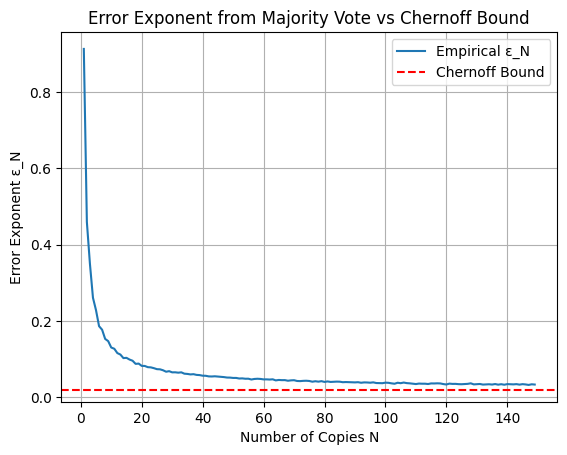

In [91]:

# Assume set_of_eps_N is a list of ε_N for N = 1 to 999
Ns = list(range(1, 150))  # N starts at 1

plt.plot(Ns, set_of_eps_N, label="Empirical ε_N")
plt.axhline(y=chernoff_error_exponent(rho0, rho1), color='r', linestyle='--', label='Chernoff Bound')
plt.xlabel("Number of Copies N")
plt.ylabel("Error Exponent ε_N")
plt.title("Error Exponent from Majority Vote vs Chernoff Bound")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
rho_plus_c, rho_minus_c = more_complex_qubit_example(0.8)
_, angles = minimum_error_probability(rho_plus_c, rho_minus_c, 1/2)
E0, E1 = func_for_POVM(*angles)
set_of_P_err_c = []
set_of_eps_N_c = []

for N in range(1, 150):
    P_err_c, epsilon_N_c = estimate_error_exponent(rho_plus_c, rho_minus_c, E0, E1, N, num_trials=10000)
    print(f"N = {N} → P_err = {P_err_c:.5f}, ε_N = {epsilon_N_c:.5f}")
    set_of_eps_N_c.append(epsilon_N_c)
    set_of_P_err_c.append(P_err_c)

N = 1 → P_err = 0.42590, ε_N = 0.85355
N = 2 → P_err = 0.43510, ε_N = 0.41609
N = 3 → P_err = 0.39340, ε_N = 0.31098
N = 4 → P_err = 0.39530, ε_N = 0.23203
N = 5 → P_err = 0.36530, ε_N = 0.20141
N = 6 → P_err = 0.37950, ε_N = 0.16148
N = 7 → P_err = 0.34700, ε_N = 0.15120
N = 8 → P_err = 0.34980, ε_N = 0.13130
N = 9 → P_err = 0.33710, ε_N = 0.12082
N = 10 → P_err = 0.33130, ε_N = 0.11047
N = 11 → P_err = 0.31840, ε_N = 0.10404
N = 12 → P_err = 0.30870, ε_N = 0.09795
N = 13 → P_err = 0.30310, ε_N = 0.09182
N = 14 → P_err = 0.30470, ε_N = 0.08489
N = 15 → P_err = 0.29290, ε_N = 0.08186
N = 16 → P_err = 0.28650, ε_N = 0.07813
N = 17 → P_err = 0.27480, ε_N = 0.07598
N = 18 → P_err = 0.27030, ε_N = 0.07268
N = 19 → P_err = 0.25610, ε_N = 0.07169
N = 20 → P_err = 0.26230, ε_N = 0.06691
N = 21 → P_err = 0.26430, ε_N = 0.06337
N = 22 → P_err = 0.25010, ε_N = 0.06300
N = 23 → P_err = 0.25620, ε_N = 0.05921
N = 24 → P_err = 0.25100, ε_N = 0.05760
N = 25 → P_err = 0.23450, ε_N = 0.05801
N = 26 → 

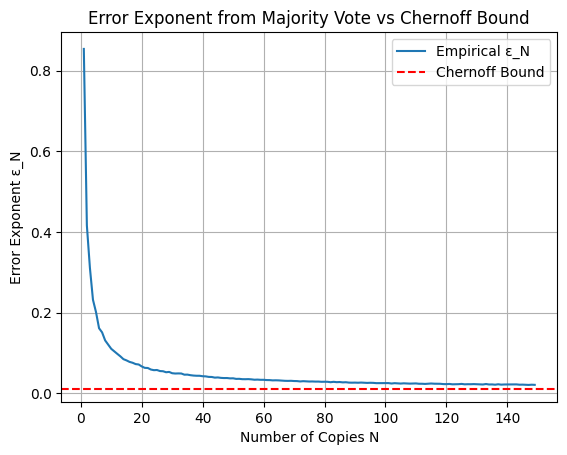

In [97]:

# Assume set_of_eps_N is a list of ε_N for N = 1 to 999
Ns = list(range(1, 150))  # N starts at 1

plt.plot(Ns, set_of_eps_N_c, label="Empirical ε_N")
plt.axhline(y=chernoff_error_exponent(rho_plus_c, rho_minus_c), color='r', linestyle='--', label='Chernoff Bound')
plt.xlabel("Number of Copies N")
plt.ylabel("Error Exponent ε_N")
plt.title("Error Exponent from Majority Vote vs Chernoff Bound")
plt.legend()
plt.grid(True)
plt.show()


In [115]:
helstrom_bound(1/2, rho_plus_c, rho_minus_c)

np.float64(0.4292893218813453)

In [116]:
cost, _ = minimum_error_probability(rho_plus_c, rho_minus_c, 1/2)

In [117]:
cost

np.float64(0.4292893218813451)

In [112]:
rho_plus_nt, rho_minus_nt = nontrivial_mixed_qubit_states(0.8)
helstrom_bound(1/2, rho_plus_nt, rho_minus_nt)


np.float64(0.4395847701320271)

In [113]:
cost, _ = minimum_error_probability(rho_plus_nt, rho_minus_nt, 1/2)

In [114]:
cost

np.float64(0.4395847701320272)

In [108]:
_, angles = minimum_error_probability(rho_plus_nt, rho_minus_nt, 1/2)
E0, E1 = func_for_POVM(*angles)
set_of_P_err_nt = []
set_of_eps_N_nt = []

for N in range(1, 150):
    P_err_nt, epsilon_N_nt = estimate_error_exponent(rho_plus_nt, rho_minus_nt, E0, E1, N, num_trials=10000)
    print(f"N = {N} → P_err = {P_err_nt:.5f}, ε_N = {epsilon_N_nt:.5f}")
    set_of_eps_N_nt.append(epsilon_N_nt)
    set_of_P_err_nt.append(P_err_nt)

N = 1 → P_err = 0.44040, ε_N = 0.82007
N = 2 → P_err = 0.43450, ε_N = 0.41678
N = 3 → P_err = 0.41290, ε_N = 0.29485
N = 4 → P_err = 0.40460, ε_N = 0.22621
N = 5 → P_err = 0.38730, ε_N = 0.18971
N = 6 → P_err = 0.39320, ε_N = 0.15557
N = 7 → P_err = 0.37450, ε_N = 0.14031
N = 8 → P_err = 0.37680, ε_N = 0.12201
N = 9 → P_err = 0.35370, ε_N = 0.11548
N = 10 → P_err = 0.35300, ε_N = 0.10413
N = 11 → P_err = 0.34830, ε_N = 0.09588
N = 12 → P_err = 0.34250, ε_N = 0.08929
N = 13 → P_err = 0.32660, ε_N = 0.08608
N = 14 → P_err = 0.32320, ε_N = 0.08068
N = 15 → P_err = 0.30720, ε_N = 0.07868
N = 16 → P_err = 0.32300, ε_N = 0.07063
N = 17 → P_err = 0.30030, ε_N = 0.07076
N = 18 → P_err = 0.30730, ε_N = 0.06555
N = 19 → P_err = 0.29120, ε_N = 0.06493
N = 20 → P_err = 0.29970, ε_N = 0.06025
N = 21 → P_err = 0.27950, ε_N = 0.06070
N = 22 → P_err = 0.28900, ε_N = 0.05642
N = 23 → P_err = 0.27620, ε_N = 0.05594
N = 24 → P_err = 0.27000, ε_N = 0.05456
N = 25 → P_err = 0.26680, ε_N = 0.05285
N = 26 → 

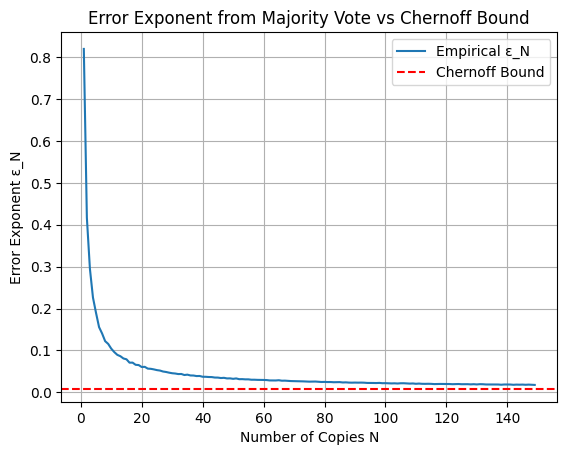

In [109]:

# Assume set_of_eps_N is a list of ε_N for N = 1 to 999
Ns = list(range(1, 150))  # N starts at 1

plt.plot(Ns, set_of_eps_N_nt, label="Empirical ε_N")
plt.axhline(y=chernoff_error_exponent(rho_plus_nt, rho_minus_nt), color='r', linestyle='--', label='Chernoff Bound')
plt.xlabel("Number of Copies N")
plt.ylabel("Error Exponent ε_N")
plt.title("Error Exponent from Majority Vote vs Chernoff Bound")
plt.legend()
plt.grid(True)
plt.show()


In [110]:
is_valid_povm([E0,E1])

True

In [119]:
rho0_cm, rho1_cm = generate_mixed_state_pair()

In [120]:
helstrom_bound(1/2, rho0_cm, rho1_cm)


np.float64(0.4888282561749867)

In [121]:
cost, angles = minimum_error_probability(rho0_cm, rho1_cm, 1/2)

In [122]:
cost

np.float64(0.48882825617500936)

In [123]:
angles

array([5.34710344, 0.72930279, 5.04209859, 0.39595549, 6.28318531,
       0.        , 1.57079633])

In [128]:
E0, E1 = func_for_POVM(*angles)
set_of_P_err_cm = []
set_of_eps_N_cm = []

for N in range(1, 100000000):
    P_err_cm, epsilon_N_cm = estimate_error_exponent(rho0_cm, rho1_cm, E0, E1, N, num_trials=10000)
    print(f"N = {N} → P_err = {P_err_cm:.5f}, ε_N = {epsilon_N_cm:.5f}")
    set_of_eps_N_cm.append(epsilon_N_cm)
    set_of_P_err_cm.append(P_err_cm)

N = 1 → P_err = 0.49430, ε_N = 0.70461
N = 2 → P_err = 0.48480, ε_N = 0.36201
N = 3 → P_err = 0.48140, ε_N = 0.24369
N = 4 → P_err = 0.48930, ε_N = 0.17869
N = 5 → P_err = 0.48530, ε_N = 0.14460
N = 6 → P_err = 0.47410, ε_N = 0.12439
N = 7 → P_err = 0.47430, ε_N = 0.10656
N = 8 → P_err = 0.47160, ε_N = 0.09395
N = 9 → P_err = 0.47730, ε_N = 0.08218
N = 10 → P_err = 0.47570, ε_N = 0.07430
N = 11 → P_err = 0.46630, ε_N = 0.06936
N = 12 → P_err = 0.47530, ε_N = 0.06198
N = 13 → P_err = 0.47160, ε_N = 0.05782
N = 14 → P_err = 0.46990, ε_N = 0.05395
N = 15 → P_err = 0.47090, ε_N = 0.05021
N = 16 → P_err = 0.46600, ε_N = 0.04772
N = 17 → P_err = 0.46820, ε_N = 0.04464
N = 18 → P_err = 0.46030, ε_N = 0.04310
N = 19 → P_err = 0.46230, ε_N = 0.04061
N = 20 → P_err = 0.46210, ε_N = 0.03860
N = 21 → P_err = 0.45740, ε_N = 0.03725
N = 22 → P_err = 0.46230, ε_N = 0.03507
N = 23 → P_err = 0.45630, ε_N = 0.03411
N = 24 → P_err = 0.45680, ε_N = 0.03265
N = 25 → P_err = 0.45740, ε_N = 0.03129
N = 26 → 

KeyboardInterrupt: 

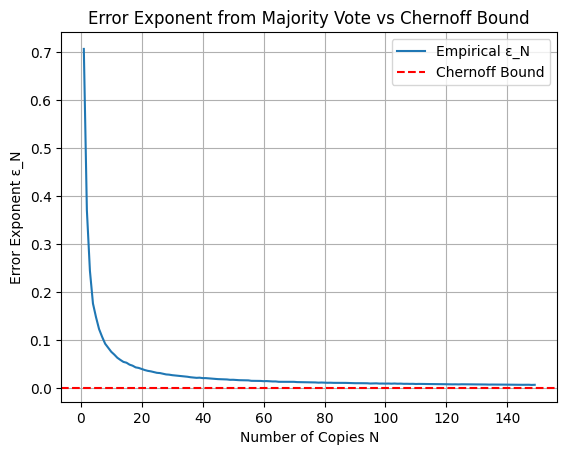

In [ ]:
Ns = list(range(1, 100000000))  # N starts at 1

plt.plot(Ns, set_of_eps_N_cm, label="Empirical ε_N")
plt.axhline(y=chernoff_error_exponent(rho0_cm, rho1_cm), color='r', linestyle='--', label='Chernoff Bound')
plt.xlabel("Number of Copies N")
plt.ylabel("Error Exponent ε_N")
plt.title("Error Exponent from Majority Vote vs Chernoff Bound")
plt.legend()
plt.grid(True)
plt.show()


In [127]:
chernoff_error_exponent(rho_plus_nt, rho_minus_nt)

np.float64(0.007390623617377795)